1. [CSV로 전체 통합](#CSV로-전체-통합)
1. [pickle로 전체 통합](#pickle로-전체-통합)

# KRX 연도별 시세 통합

https://financedata.github.io/marcap/ 에 정리된 데이터를 최신 KRX 데이터로 업데이트

 - 대상: http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101
 - 참고: https://blog.naver.com/ellijahbyeon/222213048898

> 공유: 1995년-2021년초 까지 압축 데이터  http://naver.me/5EQ0wHJ4

KRX 시세에서 Download 버튼을 누르면 excel, csv 로 구분해 다운로드가 가능하고.
 - 각 버튼을 클릭하면 Network tab에서 generated.cmd, download.cmd 에서 상세한 Post 정보를 얻을 수 있다.

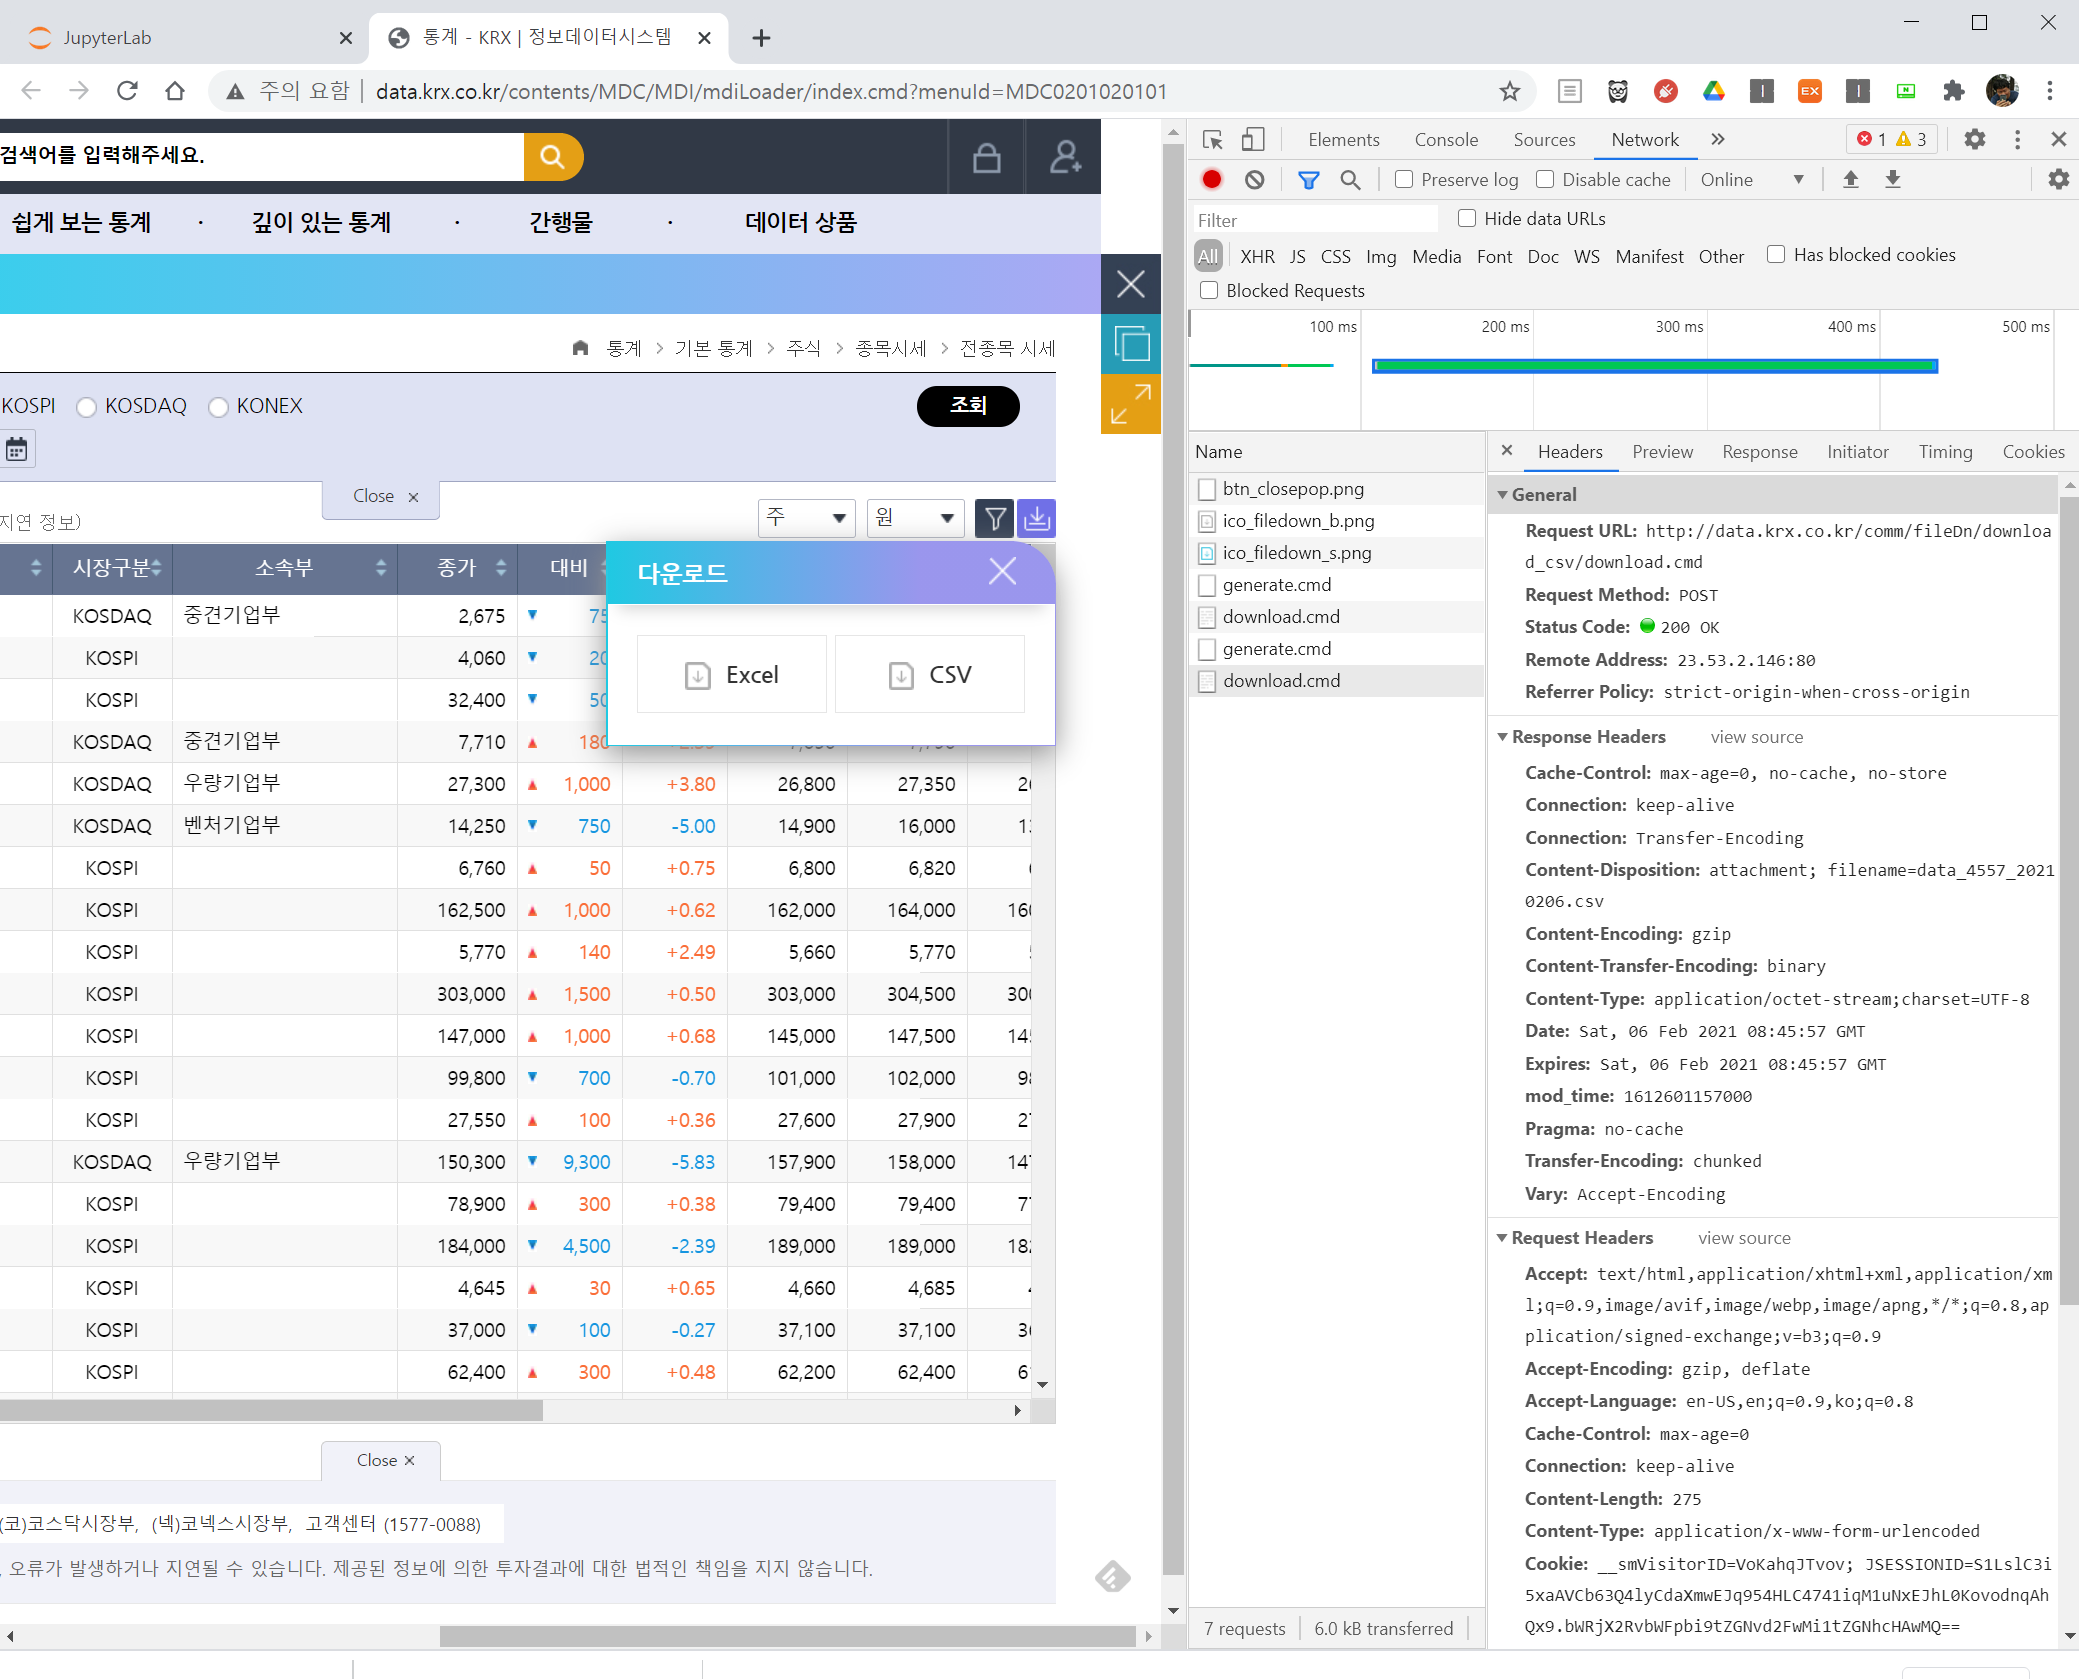

In [1]:
'''
ver: 2021-01
 - 2021년도 활동 데이터를 다운로드하고 병합한다.
'''

import time
import pandas as pd
import requests
from io import BytesIO
try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

dir_marcap = Path('../marcap/data')
dir_target = Path('data_marcap')

_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36"

def krx_basic(tdate, ext='csv'):
    '''
    Parameter tdate: 
    Parameter ext: default csv. or xlsx
    '''
    gen_req_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    query_str_parms = {
        'mktId': 'ALL',
        'trdDd': str(tdate),
        'share': '1',
        'money': '1',
        'csvxls_isNo': 'false',
        'name': 'fileDown',
        'url': 'dbms/MDC/STAT/standard/MDCSTAT01501'
    }
    headers = {
        'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': _agent #generate.cmd에서 찾아서 입력하세요
    }
    r = requests.get(gen_req_url, query_str_parms, headers=headers)
    form_data = {
        'code': r.content
    }

    if ext == 'xlsx':
        gen_req_url = 'http://data.krx.co.kr/comm/fileDn/download_excel/download.cmd'
        r = requests.post(gen_req_url, form_data, headers=headers)
        df = pd.read_excel(BytesIO(r.content))
        df['일자'] = tdate

        file_name = 'basic_'+ str(tdate) + '.xlsx'
        file_path = dir_target / file_name #Path(target_dir).joinpath(file_name)
        if file_path.exists():
            print(file_name, ' EXISTS!!!')
        else:
            df.to_excel(file_path, index=False, index_label=None)
    else:
        gen_req_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
        r = requests.post(gen_req_url, form_data, headers=headers)
        df = pd.read_csv(BytesIO(r.content), encoding='euc-kr')
        df['일자'] = tdate

        file_name = 'basic_'+ str(tdate) + '.csv'
        file_path = dir_target / file_name #Path(target_dir).joinpath(file_name)
        if file_path.exists():
            print(file_name, ' EXISTS!!!')
        else:
            df.to_csv(file_path, index=False, index_label=None, encoding='utf-8')
            
    print('KRX crawling completed :', tdate)
    return


In [70]:
def lastdate_download():
    """다운로드한 파일의 이름에서 마지막 날짜를 반환한다."""
    import os
    files = []

    for entry in os.scandir(dir_target):
        if entry.is_file():
            files.append(entry.name[6:14])
    files.sort()

    return str(files[-1:][0]) if len(files[-1:])==1 else '0'

In [66]:
lt = lastdate_download()
last_m = int(lt[-4:-2]) if lt[-4:-2]!='' else 1
last_d = int(lt[-2:]) if lt[-2:]!='0' else 1
last_m, last_d

1


(9, 17)

지정한 연도 날짜까지 데이터를 다운로드 하는데, 

- https://hwangheek.github.io/2020/pandas-custom-businessday-from-krx/

In [76]:
'''
- 21/9/20: 
    - 다운한 파일의 마지막 날짜를 읽어 이후 날짜부터 다운로드 하도록 정리
    - tqdm 처리
    
- 21/3/9: 월의 마지막 날짜 처리
    - 현재 날짜를 기준해서 종료를 처리
    - 토일 및 증시 휴장일 처리
'''
import calendar
from tqdm import tqdm

start_y = 2021
end_y = 2022

lt = lastdate_download()
last_m = int(lt[-4:-2]) if lt[-4:-2]!='' else 1
last_d = int(lt[-2:]) if lt[-2:]!='0' else 1


# 2021년 휴장일
closure = {1:[1,4], 2:[11,12], 3:[1], 4:[], 5:[5,19], 6:[],
           7:[], 8:[16], 9:[20,21,22], 10:[9], 11:[], 12:[31]}


lt = time.localtime(time.time())
print('오늘 날짜 : {}'.format(time.strftime('%Y %m %d', lt)))
print(f'시작 날짜 : {last_m}-{last_d}')

for year in tqdm(range(2021, 2022)):
    for month in tqdm(range(last_m, 13)):

        if month > lt.tm_mon:
            break
#         print('============= Download {}월 Marcap 자료 ============='.format(month))
        _, daynums = calendar.monthrange(year, month)
        for day in tqdm(range(last_d, daynums)):
            print(f'요청 날짜: {year}/{month}/{day}', end='')
            _t = time.strptime('{} {} {}'.format(year, month, day),
                               '%Y %m %d')
            # 이번달 오늘까지만 
            if (month == lt.tm_mon) and (day > lt.tm_mday):
                break
            # 이 달 1)매주 토/일, 2) 휴장일
            if (_t.tm_wday in [5,6]) or day in closure[month] :
                print("------> P ... a ... a ... s ...")
                continue
            tdate = year * 10000 + month * 100 + day * 1
            
        # downloading!!!
            krx_basic(tdate) #default csv file
            print('')

오늘 날짜 : 2021 09 21
시작 날짜 : 9-17


  0%|                                                                               | 0/4 [00:00<?, ?it/s]

  0%|                                                                              | 0/13 [00:00<?, ?it/s]

요청 날짜: 2021/9/17



 38%|██████████████████████████▉                                           | 5/13 [00:00<00:00,  9.02it/s]

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

basic_20210917.csv  EXISTS!!!
KRX crawling completed : 20210917

요청 날짜: 2021/9/18------> P ... a ... a ... s ...
요청 날짜: 2021/9/19------> P ... a ... a ... s ...
요청 날짜: 2021/9/20------> P ... a ... a ... s ...
요청 날짜: 2021/9/21------> P ... a ... a ... s ...
요청 날짜: 2021/9/22

다운로드 후 >>> [전체 데이터 병합](#전체-데이터-병합)

## 데이터 정리

각 데이터를 읽어 오며 해당 일자의 

1. 시가총액으로 정렬
1. Rank 컬럼: 시가총액 순위(rank),  
1. ChangeCode 컬럼: ChagesRatio 값: 0: 0.0, 1: , 2: -99.0~0, 영 3, 양 4, 5 )
1. MarketId 컬럼: 


이런 형태로 정리해야 한다.

```python
# 2020년까지 marcap 제공자가 정리해 저장한 자료 형태
pd.read_csv('../marcap/data/marcap-2019.csv.gz').head(3)
# pd.read_csv('../marcap/data/marcap-2019.csv.gz', index_col=0).head(3)
```

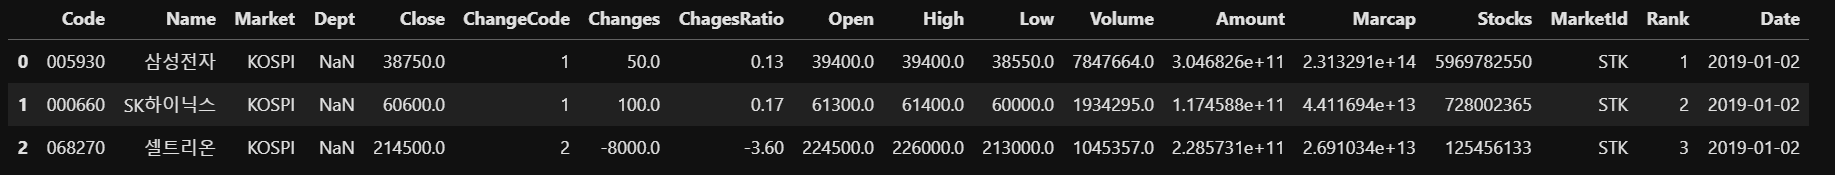

KRX에서 클롤링한 하루짜리 데이터는 아래 같이 구성되어 있다.

In [3]:
# 테스트용 2021년 자료
df = pd.read_csv( dir_target / 'basic_20210226.csv', index_col=None, header=0)
df.head()

,종목코드,종목명,시장구분,소속부,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,일자
0,060310,3S,KOSDAQ,중견기업부,2375,-70,-2.86,2410,2410,2280,260452,615086680,106405963625,44802511,20210226
1,095570,AJ네트웍스,KOSPI,NaN,3885,-100,-2.51,3890,3930,3835,55792,215881105,181904616075,46822295,20210226
2,006840,AK홀딩스,KOSPI,NaN,31250,-400,-1.26,30650,31500,30200,129822,4016595900,413986281250,13247561,20210226
3,054620,APS홀딩스,KOSDAQ,중견기업부,7720,-170,-2.15,7710,8000,7500,234499,1808593450,157443386120,20394221,20210226
4,265520,AP시스템,KOSDAQ,우량기업부,28200,-700,-2.42,27800,28350,27450,486996,13562027050,408342401400,14480227,20210226


여기에 없는 컬럼를 조립해야 한다.

In [4]:
# 컬럼 이름 변경
_ = { '종목코드': 'Code', '종목명': 'Name', '시장구분':'Market', '소속부':'Dept',
     '종가':'Close', '대비':'Changes', '등락률':'ChagesRatio', '시가':'Open', '고가':'High', '저가':'Low',
     '거래량':'Volume', '거래대금':'Amount', '시가총액':'Marcap', '상장주식수':'Stocks', '일자':'Date' }
df.rename(columns=_, inplace=True)
# 인덱스 지정
df.set_index('Code', inplace=True)

In [5]:
# 1. 시가총액으로 Sort 
df.sort_values(by='Marcap', ascending=False, inplace=True)
df.head(5)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date
Code,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,NaN,82500,-2800,-3.28,82800,83400,82000,38520800,3175845143233,492507060375000,5969782550,20210226
000660,SK하이닉스,KOSPI,NaN,141500,-7000,-4.71,143500,145000,138000,10843268,1535498840671,103012334647500,728002365,20210226
035420,NAVER,KOSPI,NaN,375000,-8000,-2.09,372000,378500,368500,1170208,436567248000,61598773125000,164263395,20210226
005935,삼성전자우,KOSPI,NaN,72800,-1300,-1.75,72700,73100,72500,3602803,262207177938,59906151760000,822886700,20210226
051910,LG화학,KOSPI,NaN,831000,-59000,-6.63,865000,867000,825000,656689,552529042526,58662237033000,70592343,20210226


In [6]:
# 2. Rank컬럼: 시가총액 순위를 매긴다
df['Rank'] = df['Marcap'].rank(ascending=False).astype(int)
df.head(10)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank
Code,,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,NaN,82500,-2800,-3.28,82800,83400,82000,38520800,3175845143233,492507060375000,5969782550,20210226,1
000660,SK하이닉스,KOSPI,NaN,141500,-7000,-4.71,143500,145000,138000,10843268,1535498840671,103012334647500,728002365,20210226,2
035420,NAVER,KOSPI,NaN,375000,-8000,-2.09,372000,378500,368500,1170208,436567248000,61598773125000,164263395,20210226,3
005935,삼성전자우,KOSPI,NaN,72800,-1300,-1.75,72700,73100,72500,3602803,262207177938,59906151760000,822886700,20210226,4
051910,LG화학,KOSPI,NaN,831000,-59000,-6.63,865000,867000,825000,656689,552529042526,58662237033000,70592343,20210226,5
005380,현대차,KOSPI,NaN,237000,-8000,-3.27,238500,248500,235500,2710962,650243538500,50639360319000,213668187,20210226,6
207940,삼성바이오로직스,KOSPI,NaN,750000,-25000,-3.23,763000,764000,750000,124989,94107831000,49623750000000,66165000,20210226,7
006400,삼성SDI,KOSPI,NaN,674000,-30000,-4.26,683000,686000,668000,579115,391065766000,46347293220000,68764530,20210226,8
035720,카카오,KOSPI,NaN,488000,3500,0.72,497500,502000,480500,1617276,791450454000,43274905480000,88678085,20210226,9


In [7]:
df.tail(5)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank
Code,,,,,,,,,,,,,,,
344860,이노진,KONEX,일반기업부,1200,0,0.00,0,0,0,0,0,2232000000,1860000,20210226,2542
001529,동양3우B,KOSPI,NaN,24300,-650,-2.61,24800,24800,24200,1171,28626400,2180244600,89722,20210226,2543
179720,옐로페이,KONEX,일반기업부,2900,0,0.00,0,0,0,0,0,2144550000,739500,20210226,2544
225850,미애부,KONEX,일반기업부,256,-43,-14.38,314,314,256,4502,1268603,853077248,3332333,20210226,2545
225860,엠앤씨생명과학,KONEX,일반기업부,63,-5,-7.35,60,66,59,27602,1668906,715559796,11358092,20210226,2546


등락코드는 기준에 따라 0,1,2,3,4,5 분류 값으로 구성되어 있다.

In [36]:
df19[df19.ChangeCode == 5][:50]

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,Date
1010,233990,질경이,KONEX,일반기업부,8800.0,5,-1500.0,-14.56,9300.0,9990.0,8800.0,6649.0,6.049074e+07,1.182720e+11,13440000,KNX,1015,2019-01-02
2198,222160,바이옵트로,KONEX,일반기업부,1785.0,5,-315.0,-15.00,1785.0,1785.0,1785.0,74.0,1.320900e+05,9.871378e+09,5530184,KNX,2259,2019-01-02
2240,223220,아이피몬스터,KONEX,일반기업부,637.0,5,-112.0,-14.95,640.0,640.0,637.0,5029.0,3.203522e+06,6.871485e+09,10787261,KNX,2309,2019-01-02
2302,135270,세종머티리얼즈,KONEX,일반기업부,268.0,5,-47.0,-14.92,315.0,315.0,268.0,79600.0,2.150380e+07,1.468710e+09,5480263,KNX,2378,2019-01-02
4346,178600,대동고려삼,KONEX,일반기업부,5950.0,5,-1050.0,-15.00,5950.0,5950.0,5950.0,150.0,8.925000e+05,2.647512e+10,4449600,KNX,2077,2019-01-03
5222,007460,에이프로젠 KIC,KOSPI,NaN,4240.0,5,-1810.0,-29.92,4240.0,4240.0,4240.0,2819639.0,1.195582e+10,2.110451e+11,49774786,STK,615,2019-01-04
6772,148780,비플라이소프트,KONEX,일반기업부,3060.0,5,-540.0,-15.00,3600.0,3600.0,3060.0,17.0,5.256000e+04,1.452190e+10,4745720,KNX,2206,2019-01-04
6778,299670,에스엠비나,KONEX,일반기업부,12500.0,5,-2200.0,-14.97,12500.0,12500.0,12500.0,100.0,1.250000e+06,1.362500e+10,1090000,KNX,2214,2019-01-04
6912,179720,옐로페이,KONEX,일반기업부,167.0,5,-29.0,-14.80,167.0,198.0,167.0,22.0,4.294000e+03,1.878750e+09,11250000,KNX,2376,2019-01-04
6915,242850,영현무역,KONEX,일반기업부,263.0,5,-46.0,-14.89,263.0,263.0,263.0,3334.0,8.768420e+05,4.260600e+08,1620000,KNX,2379,2019-01-04


In [8]:
# 3. ChangeCode 등락코드 추가
def _isplusminus(x):
    if x > 0:
        return 1
    elif x < 0:
        return 2
    else:
        return 3

In [9]:
df['ChangeCode'] = df['Changes'].map(lambda x: _isplusminus(x))

In [10]:
df.head(5)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank,ChangeCode
Code,,,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,NaN,82500,-2800,-3.28,82800,83400,82000,38520800,3175845143233,492507060375000,5969782550,20210226,1,2
000660,SK하이닉스,KOSPI,NaN,141500,-7000,-4.71,143500,145000,138000,10843268,1535498840671,103012334647500,728002365,20210226,2,2
035420,NAVER,KOSPI,NaN,375000,-8000,-2.09,372000,378500,368500,1170208,436567248000,61598773125000,164263395,20210226,3,2
005935,삼성전자우,KOSPI,NaN,72800,-1300,-1.75,72700,73100,72500,3602803,262207177938,59906151760000,822886700,20210226,4,2
051910,LG화학,KOSPI,NaN,831000,-59000,-6.63,865000,867000,825000,656689,552529042526,58662237033000,70592343,20210226,5,2


marketId 추가. marketId 는  KOSPI = STK, KOSDAQ = KSQ, KONEX = KNX 이다.

In [11]:
# 4. MarketId 추가
def _ismarket(x):
    if x == 'KOSPI':
        return 'STK'
    elif x == 'KOSDAQ':
        return 'KSQ'
    else:
        return 'KNX'

In [12]:
df['MarketId'] = df['Market'].map(lambda x: _ismarket(x))
df.head(5)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank,ChangeCode,MarketId
Code,,,,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,NaN,82500,-2800,-3.28,82800,83400,82000,38520800,3175845143233,492507060375000,5969782550,20210226,1,2,STK
000660,SK하이닉스,KOSPI,NaN,141500,-7000,-4.71,143500,145000,138000,10843268,1535498840671,103012334647500,728002365,20210226,2,2,STK
035420,NAVER,KOSPI,NaN,375000,-8000,-2.09,372000,378500,368500,1170208,436567248000,61598773125000,164263395,20210226,3,2,STK
005935,삼성전자우,KOSPI,NaN,72800,-1300,-1.75,72700,73100,72500,3602803,262207177938,59906151760000,822886700,20210226,4,2,STK
051910,LG화학,KOSPI,NaN,831000,-59000,-6.63,865000,867000,825000,656689,552529042526,58662237033000,70592343,20210226,5,2,STK


# 5. 날짜형식 변경

df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')


In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.head(5)

,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank,ChangeCode,MarketId
Code,,,,,,,,,,,,,,,,,
005930,삼성전자,KOSPI,NaN,82500,-2800,-3.28,82800,83400,82000,38520800,3175845143233,492507060375000,5969782550,2021-02-26,1,2,STK
000660,SK하이닉스,KOSPI,NaN,141500,-7000,-4.71,143500,145000,138000,10843268,1535498840671,103012334647500,728002365,2021-02-26,2,2,STK
035420,NAVER,KOSPI,NaN,375000,-8000,-2.09,372000,378500,368500,1170208,436567248000,61598773125000,164263395,2021-02-26,3,2,STK
005935,삼성전자우,KOSPI,NaN,72800,-1300,-1.75,72700,73100,72500,3602803,262207177938,59906151760000,822886700,2021-02-26,4,2,STK
051910,LG화학,KOSPI,NaN,831000,-59000,-6.63,865000,867000,825000,656689,552529042526,58662237033000,70592343,2021-02-26,5,2,STK


#### 등락률

```
등락률 = (현재가 - 전일종가) / 전일종가 x 100
```

# 전체 데이터 병합

1. 당해년도 활동 데이터를 모두 모은다
1. 이전년도 까지 데이터를 하나의 pickle로 저장한다.
1. 당해년도 활동 파일을 하나의 pickle 로 저장한다.

### 1. 당해년도 활동 데이터를 모두 모은다

In [77]:
dir_target

PosixPath('data_marcap')

In [78]:
# ChangeCode 추가
def _isplusminus(x):
    if x > 0:
        return 1
    elif x < 0:
        return 2
    else:
        return 3

# 4. MarketId 추가
def _ismarket(x):
    if x == 'KOSPI':
        return 'STK'
    elif x == 'KOSDAQ':
        return 'KSQ'
    else:
        return 'KNX'

#2021년 병합
all_files = dir_target.glob('basic_2021*.csv')
li = []

for name in tqdm(all_files):
    print(name)
    df = pd.read_csv(name, index_col=None, header=0)
    # 1.시가총액 기준 정렬
    df.sort_values(by='시가총액', ascending=False, inplace=True)

    # 2.시가총액 순위를 매긴다
    df['Rank'] = df['시가총액'].rank(ascending=False).astype(int)
    
    # 3.ChnageCode 컬럼 추가
    df['ChangeCode'] = df['대비'].map(lambda x: _isplusminus(x))
    
    # 4. 
    df['MarketId'] = df['시장구분'].map(lambda x: _ismarket(x))
    # 5.
    df['일자'] = pd.to_datetime(df['일자'], format='%Y%m%d')

    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

3it [00:00, 26.12it/s]

data_marcap/basic_20210514.csv
data_marcap/basic_20210528.csv
data_marcap/basic_20210702.csv
data_marcap/basic_20210716.csv
data_marcap/basic_20210312.csv
data_marcap/basic_20210105.csv
data_marcap/basic_20210111.csv


11it [00:00, 31.71it/s]

data_marcap/basic_20210517.csv
data_marcap/basic_20210503.csv
data_marcap/basic_20210715.csv
data_marcap/basic_20210701.csv
data_marcap/basic_20210729.csv
data_marcap/basic_20210107.csv
data_marcap/basic_20210113.csv


19it [00:00, 32.99it/s]

data_marcap/basic_20210305.csv
data_marcap/basic_20210311.csv
data_marcap/basic_20210310.csv
data_marcap/basic_20210304.csv
data_marcap/basic_20210112.csv
data_marcap/basic_20210106.csv
data_marcap/basic_20210728.csv


23it [00:00, 32.99it/s]

data_marcap/basic_20210714.csv
data_marcap/basic_20210512.csv
data_marcap/basic_20210506.csv
data_marcap/basic_20210315.csv
data_marcap/basic_20210329.csv
data_marcap/basic_20210705.csv


31it [00:01, 29.99it/s]

data_marcap/basic_20210507.csv
data_marcap/basic_20210513.csv
data_marcap/basic_20210511.csv
data_marcap/basic_20210908.csv
data_marcap/basic_20210707.csv
data_marcap/basic_20210713.csv
data_marcap/basic_20210129.csv


39it [00:01, 32.25it/s]

data_marcap/basic_20210115.csv
data_marcap/basic_20210317.csv
data_marcap/basic_20210303.csv
data_marcap/basic_20210302.csv
data_marcap/basic_20210316.csv
data_marcap/basic_20210114.csv
data_marcap/basic_20210128.csv
data_marcap/basic_20210712.csv


47it [00:01, 33.31it/s]

data_marcap/basic_20210706.csv
data_marcap/basic_20210909.csv
data_marcap/basic_20210510.csv
data_marcap/basic_20210504.csv
data_marcap/basic_20210205.csv
data_marcap/basic_20210826.csv
data_marcap/basic_20210615.csv


55it [00:01, 33.84it/s]

data_marcap/basic_20210601.csv
data_marcap/basic_20210629.csv
data_marcap/basic_20210402.csv
data_marcap/basic_20210416.csv
data_marcap/basic_20210628.csv
data_marcap/basic_20210614.csv
data_marcap/basic_20210827.csv


59it [00:01, 33.67it/s]

data_marcap/basic_20210210.csv
data_marcap/basic_20210204.csv
data_marcap/basic_20210819.csv
data_marcap/basic_20210825.csv
data_marcap/basic_20210602.csv
data_marcap/basic_20210616.csv
data_marcap/basic_20210414.csv


67it [00:02, 33.50it/s]

data_marcap/basic_20210428.csv
data_marcap/basic_20210429.csv
data_marcap/basic_20210415.csv
data_marcap/basic_20210401.csv
data_marcap/basic_20210617.csv
data_marcap/basic_20210603.csv
data_marcap/basic_20210830.csv


75it [00:02, 31.91it/s]

data_marcap/basic_20210824.csv
data_marcap/basic_20210818.csv
data_marcap/basic_20210217.csv
data_marcap/basic_20210203.csv
data_marcap/basic_20210820.csv
data_marcap/basic_20210607.csv


83it [00:02, 32.74it/s]

data_marcap/basic_20210405.csv
data_marcap/basic_20210809.csv
data_marcap/basic_20210202.csv
data_marcap/basic_20210216.csv
data_marcap/basic_20210823.csv
data_marcap/basic_20210610.csv
data_marcap/basic_20210604.csv


87it [00:02, 33.40it/s]

data_marcap/basic_20210412.csv
data_marcap/basic_20210406.csv
data_marcap/basic_20210407.csv
data_marcap/basic_20210413.csv
data_marcap/basic_20210611.csv
data_marcap/basic_20210215.csv
data_marcap/basic_20210201.csv
data_marcap/basic_20210224.csv


95it [00:02, 34.00it/s]

data_marcap/basic_20210218.csv
data_marcap/basic_20210813.csv
data_marcap/basic_20210608.csv
data_marcap/basic_20210422.csv
data_marcap/basic_20210423.csv
data_marcap/basic_20210609.csv
data_marcap/basic_20210621.csv


103it [00:03, 31.38it/s]

data_marcap/basic_20210806.csv
data_marcap/basic_20210812.csv
data_marcap/basic_20210219.csv
data_marcap/basic_20210225.csv
data_marcap/basic_20210804.csv
data_marcap/basic_20210810.csv
data_marcap/basic_20210623.csv


111it [00:03, 32.94it/s]

data_marcap/basic_20210421.csv
data_marcap/basic_20210409.csv
data_marcap/basic_20210408.csv
data_marcap/basic_20210420.csv
data_marcap/basic_20210622.csv
data_marcap/basic_20210811.csv
data_marcap/basic_20210805.csv
data_marcap/basic_20210226.csv


119it [00:03, 34.13it/s]

data_marcap/basic_20210222.csv
data_marcap/basic_20210419.csv
data_marcap/basic_20210223.csv
data_marcap/basic_20210209.csv
data_marcap/basic_20210802.csv
data_marcap/basic_20210625.csv
data_marcap/basic_20210427.csv
data_marcap/basic_20210426.csv


127it [00:03, 34.49it/s]

data_marcap/basic_20210624.csv
data_marcap/basic_20210618.csv
data_marcap/basic_20210803.csv
data_marcap/basic_20210817.csv
data_marcap/basic_20210208.csv
data_marcap/basic_20210521.csv
data_marcap/basic_20210910.csv
data_marcap/basic_20210723.csv


135it [00:04, 34.20it/s]

data_marcap/basic_20210125.csv
data_marcap/basic_20210119.csv
data_marcap/basic_20210326.csv
data_marcap/basic_20210118.csv
data_marcap/basic_20210722.csv
data_marcap/basic_20210520.csv
data_marcap/basic_20210913.csv


139it [00:04, 32.89it/s]

data_marcap/basic_20210907.csv
data_marcap/basic_20210720.csv
data_marcap/basic_20210708.csv
data_marcap/basic_20210126.csv
data_marcap/basic_20210324.csv
data_marcap/basic_20210330.csv
data_marcap/basic_20210318.csv


147it [00:04, 32.04it/s]

data_marcap/basic_20210319.csv
data_marcap/basic_20210325.csv
data_marcap/basic_20210127.csv
data_marcap/basic_20210709.csv
data_marcap/basic_20210721.csv
data_marcap/basic_20210906.csv
data_marcap/basic_20210527.csv


155it [00:04, 33.26it/s]

data_marcap/basic_20210916.csv
data_marcap/basic_20210902.csv
data_marcap/basic_20210719.csv
data_marcap/basic_20210309.csv
data_marcap/basic_20210308.csv
data_marcap/basic_20210122.csv
data_marcap/basic_20210730.csv
data_marcap/basic_20210903.csv


163it [00:04, 31.64it/s]

data_marcap/basic_20210917.csv
data_marcap/basic_20210526.csv
data_marcap/basic_20210518.csv
data_marcap/basic_20210524.csv
data_marcap/basic_20210901.csv
data_marcap/basic_20210915.csv


167it [00:05, 31.37it/s]

data_marcap/basic_20210726.csv
data_marcap/basic_20210108.csv
data_marcap/basic_20210120.csv
data_marcap/basic_20210322.csv
data_marcap/basic_20210323.csv
data_marcap/basic_20210121.csv
data_marcap/basic_20210727.csv


173it [00:05, 32.67it/s]


data_marcap/basic_20210914.csv
data_marcap/basic_20210525.csv


,종목코드,종목명,시장구분,소속부,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,일자,Rank,ChangeCode,MarketId
0,005930,삼성전자,KOSPI,NaN,80100,1600,2.04,79000,80300,78900,16450920,1313024424300,478179582255000,5969782550,2021-05-14,1,1,STK
1,000660,SK하이닉스,KOSPI,NaN,118500,1000,0.85,118500,120000,118000,3227201,383650636500,86268280252500,728002365,2021-05-14,2,1,STK
2,207940,삼성바이오로직스,KOSPI,NaN,948000,82000,9.47,901000,948000,866000,1010588,921105771000,62724420000000,66165000,2021-05-14,3,1,STK
3,005935,삼성전자우,KOSPI,NaN,73900,1700,2.35,72700,74000,72700,1058711,77733475100,60811327130000,822886700,2021-05-14,4,1,STK
4,051910,LG화학,KOSPI,NaN,854000,4000,0.47,852000,865000,846000,218492,186910631000,60285860922000,70592343,2021-05-14,5,1,STK


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442945 entries, 0 to 442944
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   종목코드        442945 non-null  object        
 1   종목명         442945 non-null  object        
 2   시장구분        442945 non-null  object        
 3   소속부         282865 non-null  object        
 4   종가          442945 non-null  int64         
 5   대비          442945 non-null  int64         
 6   등락률         442945 non-null  float64       
 7   시가          442945 non-null  int64         
 8   고가          442945 non-null  int64         
 9   저가          442945 non-null  int64         
 10  거래량         442945 non-null  int64         
 11  거래대금        442945 non-null  int64         
 12  시가총액        442945 non-null  int64         
 13  상장주식수       442945 non-null  int64         
 14  일자          442945 non-null  datetime64[ns]
 15  Rank        442945 non-null  int64         
 16  Ch

In [80]:
_ = { '종목코드': 'Code', '종목명': 'Name', '시장구분':'Market', '소속부':'Dept',
     '종가':'Close', '대비':'Changes', '등락률':'ChagesRatio', '시가':'Open', '고가':'High', '저가':'Low',
     '거래량':'Volume', '거래대금':'Amount', '시가총액':'Marcap', '상장주식수':'Stocks', '일자':'Date' }
df.rename(columns=_, inplace=True)
df.head(3)

,Code,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank,ChangeCode,MarketId
0,005930,삼성전자,KOSPI,NaN,80100,1600,2.04,79000,80300,78900,16450920,1313024424300,478179582255000,5969782550,2021-05-14,1,1,STK
1,000660,SK하이닉스,KOSPI,NaN,118500,1000,0.85,118500,120000,118000,3227201,383650636500,86268280252500,728002365,2021-05-14,2,1,STK
2,207940,삼성바이오로직스,KOSPI,NaN,948000,82000,9.47,901000,948000,866000,1010588,921105771000,62724420000000,66165000,2021-05-14,3,1,STK


In [81]:
# 저장시 인덱스는 해지를 하고 저장한다.
df.to_csv('data/marcap-2021.csv.gz', index=False, compression='gzip')

In [82]:
del df

In [83]:
# 저장된 데이터 확인
df = pd.read_csv('data/marcap-2021.csv.gz').head(3)
# pd.read_csv('../marcap/data/marcap-2021.csv.gz', index_col=0).head(3)
df.head()

,Code,Name,Market,Dept,Close,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,Date,Rank,ChangeCode,MarketId
0,005930,삼성전자,KOSPI,NaN,80100,1600,2.04,79000,80300,78900,16450920,1313024424300,478179582255000,5969782550,2021-05-14,1,1,STK
1,000660,SK하이닉스,KOSPI,NaN,118500,1000,0.85,118500,120000,118000,3227201,383650636500,86268280252500,728002365,2021-05-14,2,1,STK
2,207940,삼성바이오로직스,KOSPI,NaN,948000,82000,9.47,901000,948000,866000,1010588,921105771000,62724420000000,66165000,2021-05-14,3,1,STK


In [24]:
del df

#### 미원상사 주가

https://m.blog.naver.com/ellijahbyeon/222118489806

# CSV로 전체 통합

1995년 부터 현재까지 시가총액 csv 파일을 한 파일로 결합해 csv 로 출력한다.

In [2]:
end_y = time.localtime().tm_year - 1 # 전년도까지
end_y

2020

In [1]:
%%writefile krx_all_marcap.py
'''
v1.1 1995부터 올해까지 파일을 추가
'''
import pandas as pd

start_y = 1995
end_y = time.localtime().tm_year # 현재 년도까지
print(f"{start_y} 에서 {end_y}까지 데이터 결합 ---- ")
target_file = Path(f'data/marcap_{start_y}-{end_y}.csv.gz')

li = []
print('')
for year in range(1995, end_y):
    file = Path(f'../marcap/data/marcap-{year}.csv.gz')
    if file.exists():
        chunk = pd.read_csv(file, chunksize=2000000)
        for c in chunk:
            li.append(c)

        print(file, ': ', file.stat().st_size, end=', ')

df_all = pd.concat(li, axis=0, ignore_index=True)
print('Total: ', df_all.shape)

df_all.to_csv(target_file, index=False, chunksize=2000000, compression='gzip')

Writing krx_all_marcap.py


In [3]:
!ls data/*.csv.gz

data/marcap-1995.csv.gz      data/marcap-2009.csv.gz
data/marcap-1996.csv.gz      data/marcap-2010.csv.gz
data/marcap-1997.csv.gz      data/marcap-2011.csv.gz
data/marcap-1998.csv.gz      data/marcap-2012.csv.gz
data/marcap-1999.csv.gz      data/marcap-2013.csv.gz
data/marcap-2000.csv.gz      data/marcap-2014.csv.gz
data/marcap-2001.csv.gz      data/marcap-2015.csv.gz
data/marcap-2002.csv.gz      data/marcap-2016.csv.gz
data/marcap-2003.csv.gz      data/marcap-2017.csv.gz
data/marcap-2004.csv.gz      data/marcap-2018.csv.gz
data/marcap-2005.csv.gz      data/marcap-2019.csv.gz
data/marcap-2006.csv.gz      data/marcap-2020.csv.gz
data/marcap-2007.csv.gz      data/marcap-2021.csv.gz
data/marcap-2008.csv.gz      data/marcap_1995-2021.csv.gz


In [ ]:
%time !cat data/*.csv.gz > data/marcap_1995-2021.csv.gz

In [ ]:
%time !python krx_all_marcap.py

```python
'''
v1. 1995부터 올해까지 파일을 추가
'''
import pickle as pickle

start_y = 1995
end_y = time.localtime().tm_year # 현재 년도까지
print(f"{start_y} 에서 {end_y}까지 데이터 결합 ---- ")
target_file = Path(f'data/marcap_{start_y}-{end_y}.csv.gz')

li = []
for year in range(1995, end_y):
    file = Path(f'../marcap/data/marcap-{year}.csv.gz')
    if file.exists():
        #_ = pd.read_csv(file, parse_dates=['Date'], index_col=0)
        _ = pd.read_csv(file)
        li.append(_)
        print(file, ': ', _.shape, end=', ')

df_all = pd.concat(li, axis=0, ignore_index=True)
df_all.to_csv(target_file, index=False, compression='gzip')
```

In [1]:
del df_all; del li;

NameError: name 'df_all' is not defined

# pickle로 전체 통합

1. 당해년도 활동 중인 파일을 하나의 pickle 로 저장한다.
2. 1995년 부터 이전 년도까지 데이터를 하나의 pickle로 저장한다.
3. 1995년 부터 올해까지 데이터를 하나의 pickle로 저장.

### 1. 당해년도 활동 파일을 하나의 pickle 로 저장한다.

### 2. 1995년 부터 이전 년도까지 데이터를 하나의 pickle로 저장한다.

`marcap/data` 밑에 있는 1995년 부터 2020년까지 데이터를 병합해 하나의 피클 파일로 저장한다.

In [51]:
# 저장된 데이터 확인
pd.read_csv('../marcap/data/marcap-2019.csv.gz').head(3)

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,Date
0,005930,삼성전자,KOSPI,NaN,38750.0,1,50.0,0.13,39400.0,39400.0,38550.0,7847664.0,3.046826e+11,2.313291e+14,5969782550,STK,1,2019-01-02
1,000660,SK하이닉스,KOSPI,NaN,60600.0,1,100.0,0.17,61300.0,61400.0,60000.0,1934295.0,1.174588e+11,4.411694e+13,728002365,STK,2,2019-01-02
2,068270,셀트리온,KOSPI,NaN,214500.0,2,-8000.0,-3.60,224500.0,226000.0,213000.0,1045357.0,2.285731e+11,2.691034e+13,125456133,STK,3,2019-01-02


In [8]:
'''
1. 1995부터 올해까지 파일을 추가
'''
import pickle as pickle

start_y = 1995
end_y = time.localtime().tm_year - 1 # 전년도까지
print(f"{start_y} 에서 {end_y}까지 데이터 결합 ---- ")
target_file = Path(f'../marcap_{start_y}-{end_y}.pkl') # 작년까지
if target_file.exists():
    print(f'{target_file} is EXISTS!!!' )
    with open(target_file, 'rb') as f:
        df_pre = pickle.load(f)

else:
    li = []
    for year in range(start_y, end_y):
        file = Path(f'../marcap/data/marcap-{year}.csv.gz')
        if file.exists():
            #_ = pd.read_csv(file, parse_dates=['Date'], index_col=0)
            _ = pd.read_csv(file)
            li.append(_)
            print(file, ': ', _.shape, end=', ')

    df_pre = pd.concat(li, axis=0, ignore_index=True)
    df_pre.to_pickle(target_file) # 작년까지
print('')
print(df_pre.shape)

1995 에서 2020까지 데이터 결합 ---- 
..\marcap_1995-2020.pkl is EXISTS!!!

(10490213, 18)


In [5]:
# ignoreindex=true 결과
df_pre.head()

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,Date
0,15760,한국전력공사,KOSPI,NaN,27400.0,2,-400.0,-1.44,27600.0,27800.0,27400.0,118190.0,3.255694e+09,1.687268e+13,615791215,STK,1,1995-05-02
1,5930,삼성전자,KOSPI,NaN,119500.0,2,-1000.0,-0.83,121000.0,121000.0,118500.0,139560.0,1.667674e+10,6.497053e+12,54368645,STK,2,1995-05-02
2,5490,포항종합제철,KOSPI,NaN,65500.0,2,-300.0,-0.46,65800.0,66200.0,65400.0,65970.0,4.334472e+09,6.150569e+12,93901810,STK,3,1995-05-02
3,200,대우중공업,KOSPI,NaN,9800.0,1,300.0,3.16,9500.0,9840.0,9500.0,288380.0,2.805134e+09,3.500639e+12,357208059,STK,4,1995-05-02
4,2610,엘지전자,KOSPI,NaN,31700.0,2,-300.0,-0.94,32000.0,32000.0,31700.0,171460.0,5.452050e+09,2.521027e+12,79527666,STK,5,1995-05-02


### 3. 모든 년도 통합

In [6]:
with open('../marcap_2021.pkl', 'rb') as f:
    df = pickle.load(f)
    df_all = pd.concat([df_pre, df], axis=0, ignore_index=True)
    print(df_all.shape)

(10612105, 18)


In [56]:
df_all.head(5)

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank,Date
0,15760,한국전력공사,KOSPI,NaN,27400.0,2,-400.0,-1.44,27600.0,27800.0,27400.0,118190.0,3.255694e+09,1.687268e+13,615791215,STK,1,1995-05-02
1,5930,삼성전자,KOSPI,NaN,119500.0,2,-1000.0,-0.83,121000.0,121000.0,118500.0,139560.0,1.667674e+10,6.497053e+12,54368645,STK,2,1995-05-02
2,5490,포항종합제철,KOSPI,NaN,65500.0,2,-300.0,-0.46,65800.0,66200.0,65400.0,65970.0,4.334472e+09,6.150569e+12,93901810,STK,3,1995-05-02
3,200,대우중공업,KOSPI,NaN,9800.0,1,300.0,3.16,9500.0,9840.0,9500.0,288380.0,2.805134e+09,3.500639e+12,357208059,STK,4,1995-05-02
4,2610,엘지전자,KOSPI,NaN,31700.0,2,-300.0,-0.94,32000.0,32000.0,31700.0,171460.0,5.452050e+09,2.521027e+12,79527666,STK,5,1995-05-02


In [7]:
df_all.to_pickle('../marcap_1995-2021.pkl')